# Ising Adiabatic State Preparation

---

## *Review*: Postulate 6

>The time evolution of the state vector $\ket{\psi(t)}$ is governed by the Schrödinger
equation:
$$ 		i\hbar\frac{d}{dt}\ket{\psi(t)} = \hat{H}(t)\ket{\psi(t)},$$

### Time independent case

Imagine the case where $\hat{H}(t) \neq f(t)$. This is just a statement that the Hamiltoninan operator doesn't change in time. 
If that is the case, then we can directly integrate this differential equation, to get the following solution:
$$\begin{align}
\ket{\psi(t)} =& e^{\frac{-i}{\hbar}\hat{H}\Delta t}\ket{\psi(t_0)}, \\
=& U(t,t_0)\ket{\psi(t_0)}
\end{align}
$$
where $\Delta t = t-t_0$. Differentiate this wavefunction to convince yourself that this is a solution to the time dependent Schrödinger equation.  

Because of this simple form, we can do fancy things, like first go to $t_1$, then go to $t_2$, e.g., 
$$\begin{align}
\ket{\psi(t_2)} = U(t_2,t_1)U(t_1,t_0)\ket{\psi(t_0)}
\end{align}
$$

### Time dependent case

The more general (and complicated) case where $\hat{H}$ is time-dependent cannot be written down in such a simple form. However, we can develop an arbitrarily accurate approximation to the solution by using the result above. 
Assume we want to solve for $\ket{\psi(t)}$, we can break up the evolution into _infinitely_ many steps:
$$\begin{align}
\ket{\psi(t)} = \lim_{N\rightarrow \infty} U(t,t_{N-1})\dots U(t_2,t_1) U(t_1,t_0)\ket{\psi(t_0)}
\end{align}$$
By dividing the evolution into small enough time steps, we can use the time independent solution!
The core idea, is that within a small enough time window, $t_i \rightarrow t_{i+1}$, the Hamiltonian is changing slowly enough such that it appears constant. This means that whatever the Hamiltonian looks like at a give time, ($\hat{H}(t_i)$), we can exponentiate it, to obtain a unitary $U(t_{i+1}, t_i)$.

In practice, of course, we can never write down a real $\infty$ of terms. And so we simply stop at some point and accept that there is some approximation being made. 
$$\begin{align}
\ket{\psi(t)} \approx   U(t,t_{N-1})\dots U(t_2,t_1) U(t_1,t_0)\ket{\psi(t_0)}
\end{align}$$

We often refer to this particular approximate form of the time evolution as being `trotterized`

---



## Adiabatic Principle

We can use the above result (the "trotterized" form of the TDSE solution) to solve a generally difficult problem, __finding the ground state of a Hamiltonian__. 
In our Ising case, this amounts to finding the lowest energy spin configuration out of an exponentially large number of candidates. However, if we were to be able to find the ground state, we would simultaneously be solving a wide range of extremely important problems including the travelling salesman problem or finding the max-cut of a graph or network. 

In this notebook, we will use the `adiabatic principle` to define an interesting (yet simple) quantum algorithm for obtaining arbitrarily accurate approximations to Hamiltonian ground states. 

We will define the adiabatic principle as follows:
>If we start out in the ground state of a Hamiltonian $\hat{H}_A$, and the _slowly_ move to Hamiltonian $\hat{H}_B$, then we will end up in the ground state of $\hat{H}_B$ (assuming we move slow enough and there is a gap).


To use the adiabatic principle to obtain the ground state for a target Hamiltonian, $\hat{H}_B$, (which could be the Ising example we have been working with or some other problem) we will define the following time dependent Hamiltonian:
$$\begin{align}
\hat{H}(t) = f(t) \hat{H}_A + (1-f(t)) \hat{H}_B,
\end{align}$$
where $\hat{H}_A$ is our starting Hamiltonian (this should be an easy Hamiltonian for which we know the ground state). Notice that while both $\hat{H}_A$ and $\hat{H}_B$ are time-_independent_, the coefficent  $f(t)$ changes in time, so the total Hamiltonian is time-_dependent_.  

This means that we can define any function $f(t)$ that starts at 1 and ends up equal to 0 at some final time, $t_f$.
- $f(t_0) = 1$
- $f(t_f) = 0$

We will consider a simple linear interpolation between the two Hamiltonians as illustrated below:


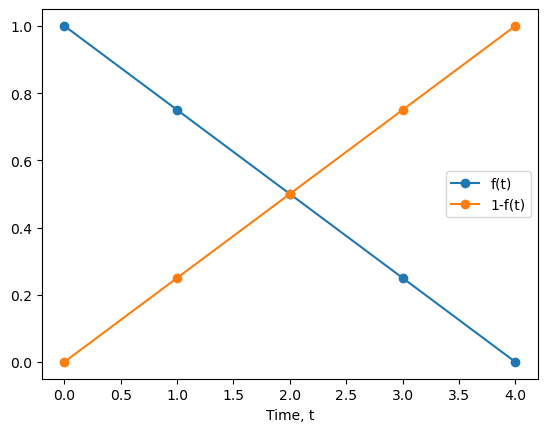

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.linspace(1,0,5), marker='o', label="f(t)");
plt.plot(np.linspace(0,1,5), marker='o', label="1-f(t)");
plt.xlabel("Time, t");
plt.legend();


If we move _slowly enough_, then we are guaranteed to stay in the ground state. 
Additionally, if we move _slowly enough_ then we can also treat the Hamiltonian as a sequence of time-independent Hamiltonians (this is the `trotter` approximation)!

Using $t_0=0$, $t_f=4$, and $N=4$ from the case above we can define the solution as:
$$
\begin{align}
\ket{\psi(t_f)} &= e^{\tfrac{-i\Delta t}{\hbar}\hat{H}_B}e^{\tfrac{-i\Delta t}{\hbar}\left(.25\hat{H}_A+.75\hat{H}_B\right)}e^{\tfrac{-i\Delta t}{\hbar}\left(.5\hat{H}_A+.5\hat{H}_B\right)}e^{\tfrac{-i\Delta t}{\hbar}\left(.75\hat{H}_A+.25\hat{H}_B\right)}e^{\tfrac{-i\Delta t\Delta t}{\hbar}\hat{H}_A}\ket{\psi(0)}\\
&= U(4,3)U(3,2)U(2,1)U(1,0)\ket{\psi(0)}
\end{align}
$$

We can use a quantum computer to carry out these operations. But first we will need to know how to represent these quantities on a quantum computer.


# Quantum Representation of Ising  

In the previous examples, we have used `classical' bitstrings, by which I mean all of our states are always written as a single product of zeros and ones, i.e., $\ket{010010}$. So far, we have used the Ising Hamiltonian, 
$$ \hat{H} = \sum_{(i,j)\in E}J_{ij} s_is_j + \sum_i \mu_i s_i,$$
to compute the energy of these bitstrings where the spin function takes in a bit and returns either 1 or -1. For example, if $\ket{\psi}=\ket{0101}$, then $s_2\ket{0101}=0$. 

We can make this a bit more mathematically useful, and define our quantities in terms of linear algebra, making our spin function and operator, and the state a vector. Each bit is two-dimensional (it can be either zero or one), so we can express it as a 2-dimensional vector:

$$
\ket{0} = \begin{pmatrix}1 \\ 0\end{pmatrix},
\text{ }~ 
\ket{1} = \begin{pmatrix}0 \\ 1\end{pmatrix} 
$$

Similarly, our "spin-functions", $s_i$, can also be expressed in terms of a simple, linear algebra quantity, $\hat{z}$  
\begin{align}
\hat{z} = \begin{pmatrix}1 & 0 \\ 0 &-1\end{pmatrix}
\end{align}

Consider the following operator, $\hat{x}$:
\begin{align}
\hat{x} = \begin{pmatrix}0 & 1 \\ 1 &0\end{pmatrix}
\end{align}

What happens when we apply $\hat{x}$ to our states?
\begin{align}
\hat{x}\ket{0} =& \ket{1} \\ 
\hat{x}\ket{1} =& \ket{0} 
\end{align}

Here, $\hat{z}$ tells us about the spin being spin-up or spin down. And $\hat{x}$, flips the state between up and down. However, because our bits are quantum states (vectors), they can also point in other directions besides up and down - this is a key difference between quantum an classical computers!

Consider the last operator/gate we will need, $\hat{U}^H$:
\begin{align}
\hat{U}^H =& \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 &-1\end{pmatrix} \\
    =& \frac{1}{2}\left(\hat{x}+\hat{z}\right)
\end{align}

Applying this operator to a state does something interesting:
\begin{align}
\hat{U}^H\ket{0} =& \frac{1}{2}\left(\hat{x}+\hat{z}\right)\ket{0} \\
=& \frac{1}{2}\left(\ket{1} + \ket{0}\right) \\  
\hat{U}^H\ket{1} =& \frac{1}{2}\left(\hat{x}+\hat{z}\right)\ket{1} \\
=& \frac{1}{2}\left(\ket{0} - \ket{1}\right) \\  
\end{align}

We've now created `superposition` states! Play around with these objects in the following python cell. 

In [2]:
import numpy as np

# define our qubit states
s0 = np.array([[1],[0]])
s1 = np.array([[0],[1]])

# define z     
z = np.array([[1,0],[0,-1]])
print(" z operator: \n", z)

# define x
x = np.array([[0,1],[1,0]])
print(" x operator: \n", x)

# define Uh 
Uh = np.array([[1,1],[1,-1]])/np.sqrt(2)
print(" Uh operator: \n", Uh)

print("\n z|0>: \n", z@s0)
print("\n z|1>: \n", z@s1)

print("\n x|0>: \n", x@s0)
print("\n x|1>: \n", x@s1)

print("\n Uh|0>: \n", Uh@s0)
print("\n Uh|1>: \n", Uh@s1)

print("\n |0>⊗|1>: \n", np.kron(s0,s1))
print("\n z⊗z    : \n", np.kron(z,z))

 z operator: 
 [[ 1  0]
 [ 0 -1]]
 x operator: 
 [[0 1]
 [1 0]]
 Uh operator: 
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

 z|0>: 
 [[1]
 [0]]

 z|1>: 
 [[ 0]
 [-1]]

 x|0>: 
 [[0]
 [1]]

 x|1>: 
 [[1]
 [0]]

 Uh|0>: 
 [[0.70710678]
 [0.70710678]]

 Uh|1>: 
 [[ 0.70710678]
 [-0.70710678]]

 |0>⊗|1>: 
 [[0]
 [1]
 [0]
 [0]]

 z⊗z    : 
 [[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]


# **Question**: 
In the next cell: explain what $\hat{U}^H$ does to the states, $\ket{0}$ and $\ket{1}$ in terms of $\hat{x}$.:

$\hat{x}$ has two eigenvalues: +1 and -1. As a result, when passing a 0 through, it results in an equal part superposition between $\frac{1}{\sqrt{2}} * (\ket{1} + \ket{0})$, where the first value gets flipped, and the second value revieces treatment of phase change as shown from when 1 is passed, and results in $\frac{1}{\sqrt{2}} * (\ket{0} - \ket{1})$ to be outputted. 

---

## Adiabatic Evolution of Ising Hamiltonian with Quantum Circuit

We discussed that the adiabatic principle can be used to obtain the ground state of a difficult problem (e.g., Ising Hamiltonian) by starting with an easy problem (which for which we know the solution) and slowly moving toward the difficult solution. This means that we need to _drive our system forward in time_ with a time-dependent Hamiltonian. 
This is generally a difficult task, but we can leverage a quantum computer to do this for us!

By choosing $\hat{H}_0 = - \sum_i \sigma_i^x$, 
recall that the ground state of the Ising model can be prepared by the following sequence of time evolutions:
$$
\ket{\psi(t_f)} = U(4,3)U(3,2)U(2,1)U(1,0)\ket{\psi(0)}
$$
which is, 
$$
\ket{\psi(t)} = e^{\tfrac{-i}{\hbar}\hat{H}_1\Delta t}e^{\tfrac{-i}{\hbar}\left(.25\hat{H}_0+.75\hat{H}_1\right)\Delta t}e^{\tfrac{-i}{\hbar}\left(.5\hat{H}_0+.5\hat{H}_1\right)\Delta t}e^{\tfrac{-i}{\hbar}\left(.75\hat{H}_0+.25\hat{H}_1\right)\Delta t}e^{\tfrac{-i}{\hbar}\hat{H}_0\Delta t}\ket{\psi(0)},
$$
where $N\Delta t = t$.

Here the basic idea is to use a quantum computer to do this time evolution for us. We will use the fact that Qiskit defines for us the following gates (or operations):

Single qubit gates (applied to a given qubit `n`):
- `h(n)`: $\hat{U}^H$ 
- `rx(θ,n)`: $e^{i\tfrac{\theta}{2} \hat{x}}$
- `rz(θ,n)`: $e^{i\tfrac{\theta}{2} \hat{z}}$

Two qubit gates (applied to two given qubits, `n` and `m`):
- `rzz(θ,n,m)`: $e^{i\tfrac{\theta}{2} \hat{z}_n\otimes \hat{z}_m}$

### Trotterization
One trick we will use is `Trotterization`. For 2 operators $\hat{o}_1$ and $\hat{o}_2$, we can say the following two things:
- if $\hat{o}_1\hat{o}_2 = \hat{o}_2\hat{o}_1$, then $e^{a\left(\hat{o}_1 + \hat{o}_2\right)} = e^{a\hat{o}_1}e^{a\hat{o}_2}$
- if $\hat{o}_1\hat{o}_2 \neq \hat{o}_2\hat{o}_1$ but $a\ll 1$, then $e^{a\left(\hat{o}_1 + \hat{o}_2\right)} \approx e^{a\hat{o}_1}e^{a\hat{o}_2}$

Where we say that $\hat{o}_1$ and $\hat{o}_2$ `commute` if $\hat{o}_1\hat{o}_2 = \hat{o}_2\hat{o}_1$

## Initialization

From our discussion before, we saw that applying a Hadamard gate to the $\ket{0}$ state created the $\ket{+}$ state, 
which happened to be the +1 eigenstate of $\sigma_x$:
- $\sigma_x\ket{+} = \ket{+}$

As such, we can initialize our system in the ground state of $\hat{H}_0$ by simply applying a Hadamard to each qubit. 

---
For this notebook, we'll use Qiskit, which will need to be installed into your environment:

```
pip install qiskit
pip install qiskit-aer
pip install pylatexenc
```
---

/tmp/ipykernel_520962/2132263217.py:7: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  sim = Aer.get_backend('statevector_simulator')
/home/dyk6704/miniconda3/envs/molssi_best_practices/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


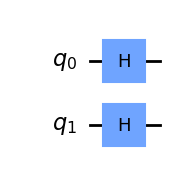

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.tools.visualization import plot_histogram
# from qiskit.tools.visualization import plot_bloch_multivector

sim = Aer.get_backend('statevector_simulator')

circ = QuantumCircuit(2,0)
circ.h(0)
circ.h(1)
circ.draw(output = 'mpl')

/tmp/ipykernel_520962/2706169862.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))
/tmp/ipykernel_520962/2706169862.py:1: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))


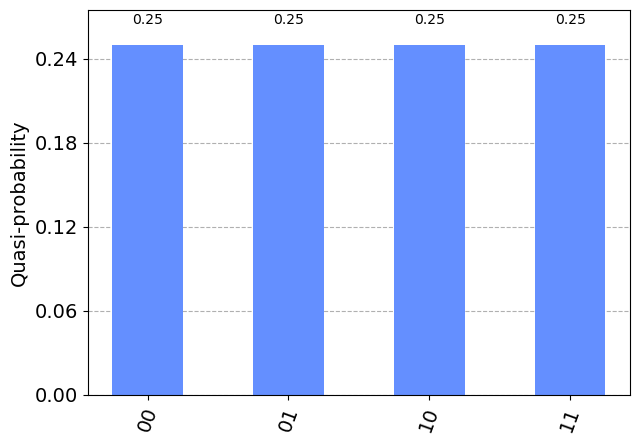

In [4]:
plot_histogram(execute(circ, backend = sim).result().get_counts(circ))

## First time step

How do we implement $e^{-i\hat{H}_0\Delta t}$ with gates? Let's make things more concrete first, and consider a simple 2-site Ising problem. 
- $ \hat{H}_0 = - \sigma^x_0 - \sigma^x_1$
- $ \hat{H}_1 = J\sigma^z_0\sigma^z_1 + \mu\sigma^z_0 + \mu\sigma^z_1$
- $J = 1$
- $\mu = .1$

Because $\sigma_0^x$ and $\sigma_1^x$ act on different qubits, they commute, meaning that we can break this first time step up into 2 sequential steps exactly:
$$ 
e^{i\left(\sigma_0^x + \sigma_1^x\right)\Delta t} = e^{i\sigma_0^x\Delta t} e^{i\sigma_1^x\Delta t} 
$$

Let's choose a small time step, say $\Delta t = .1$. 
We can use the following quantum circuit to implement this time step:

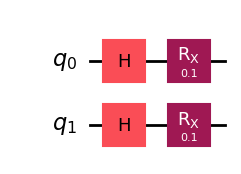

In [5]:
circ = QuantumCircuit(2,0)
circ.h(0)
circ.h(1)
circ.rx(.1,1)
circ.rx(.1,0)
circ.draw(output = 'mpl', style="iqp")

/tmp/ipykernel_520962/2706169862.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))
/tmp/ipykernel_520962/2706169862.py:1: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))


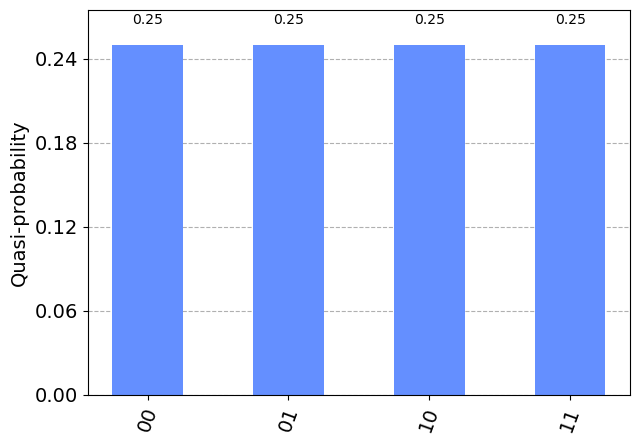

In [6]:
plot_histogram(execute(circ, backend = sim).result().get_counts(circ))

# **Question**: 
Explain why the measured probability stayed the same in the above plot:

We are currently measuring probability using 2 qubits. So there is a total combination of $2^2 = 4$ configurations the qubits can take. As each of these states have the same weight and probability from one another, the probability remained the same at each configuration of $\frac{1}{4} = 0.25$.

---

## Second time step

Now we must implement the following operator: $e^{-i\left(.75\hat{H}_0 + .25\hat{H}_1\right)\Delta t}$. 

Unfortunately, $\sigma^z\sigma^x \neq \sigma^z\sigma^x$ and so we can't exactly trotterize this. 
However, because $\Delta t \ll 1$, we can approximate this in a product form, and this will become increasingly more accurate as we take smaller time steps. 

$$ \hat{H}_0 = - \sigma^x_0 - \sigma^x_1$$
$$ \hat{H}_1 = J\sigma^z_0\sigma^z_1 + \mu\sigma^z_1 + \mu\sigma^z_1$$

$$
e^{-i\left(- .75\sigma^x_0 - .75\sigma^x_1 + .25 J\sigma^z_0\sigma^z_0 + .25\mu\sigma^z_1 + .25\mu\sigma^z_1\right)\Delta t}
\approx
e^{.75 i\sigma^x_0\Delta t} 
e^{.75 i\sigma^x_1\Delta t}
e^{-.25 i J\sigma^z_0\sigma^z_1 \Delta t}
e^{-.25 i \mu\sigma^z_0 \Delta t}
e^{-.25 i \mu\sigma^z_1 \Delta t}
$$

Notice here that we are using a new gate, `RZZ`. 
This is a 2-qubit gate that rotates about the product of two $\sigma^z$ operators.

/home/dyk6704/miniconda3/envs/molssi_best_practices/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


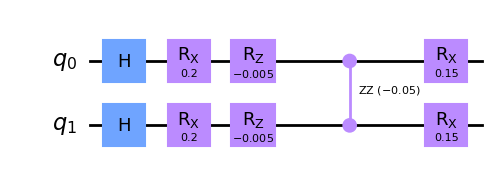

In [7]:
circ = QuantumCircuit(2,0)
# initialize
circ.h(0)
circ.h(1)

# time step 1
circ.rx(2*.1,1)
circ.rx(2*.1,0)

# time step 2
circ.rz(-2*.0025,1)
circ.rz(-2*.0025,0)
circ.rzz(-2*.025,0,1)
circ.rx(2*.075,1)
circ.rx(2*.075,0)

circ.draw(output = 'mpl')

From here we can recognize the pattern and start to generalize with a function!


## Automate the circuit building

Because each step will have the same gates, but different angles, we can simply write a function to create the circuit. 

In [8]:
import montecarlo

def form_circuit(beta, ham: montecarlo.IsingHamiltonian):
    """
    Form the circuit for adiabatic evolution
    
        H = J\sum_{ij} \sigma_i^z \sigma_j^z + \mu\sum_i\sigma_i^z
    """
    N = len(ham.J)
    circ = QuantumCircuit(N, 0)
    
    dt = 1 / (len(beta) - 1)


    for i in range(N):
        circ.h(i)
    
    for b in beta:
        for j in range(N):
            circ.rz(-N*ham.mu[j]*(1-b)*dt, j)
        for j in range(len(ham.J)):
            for coupling in ham.J[j]:
                circ.rzz(-N*coupling[1]*(1-b)*dt, j, coupling[0])
        for j in range(N):
            circ.rx(N*b*dt, j)

    return circ    


## Plot for Arbitrary steps and qubits

Try out different numbers of steps and different Hamiltonians. 
- $\hat{H}(t) = \beta(t)\hat{H}_0 + \gamma(t)\hat{H}_1$

In [9]:
# form Hamiltonian
def build_1d_Hamiltonian(N, Jval, mu=0.0):
    """
    Build a 1D Hamiltonian with a single J value (Jval)
    """
    mus = [0.0 for i in range(N)]
    J = [[] for i in range(N)]
    for site in range(N-1):
        J[site].append((site+1, Jval + .1*site))
    return montecarlo.IsingHamiltonian(J,mus)

ham = build_1d_Hamiltonian(N=4, Jval=1)

# let's add a local mu value to the first spin
ham.mu[0] = -1.2 


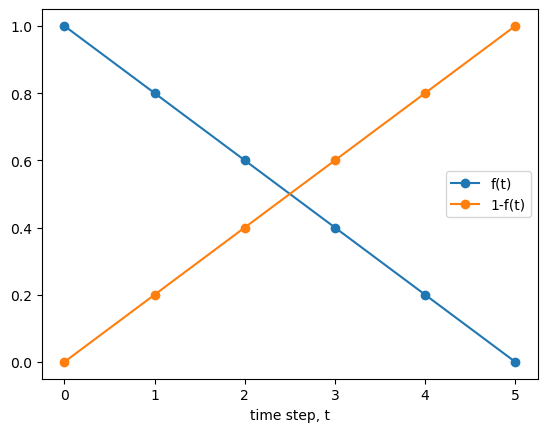

In [10]:
# create the adiabatic parameters
n_steps = 5
beta = []
gamma = []
for i in range(n_steps+1):
    beta.append(1-i/n_steps)
    gamma.append(i/n_steps)

plt.plot(beta, label="f(t)", marker="o")
plt.plot(gamma, label="1-f(t)", marker="o");
plt.xlabel("time step, t")
plt.legend();

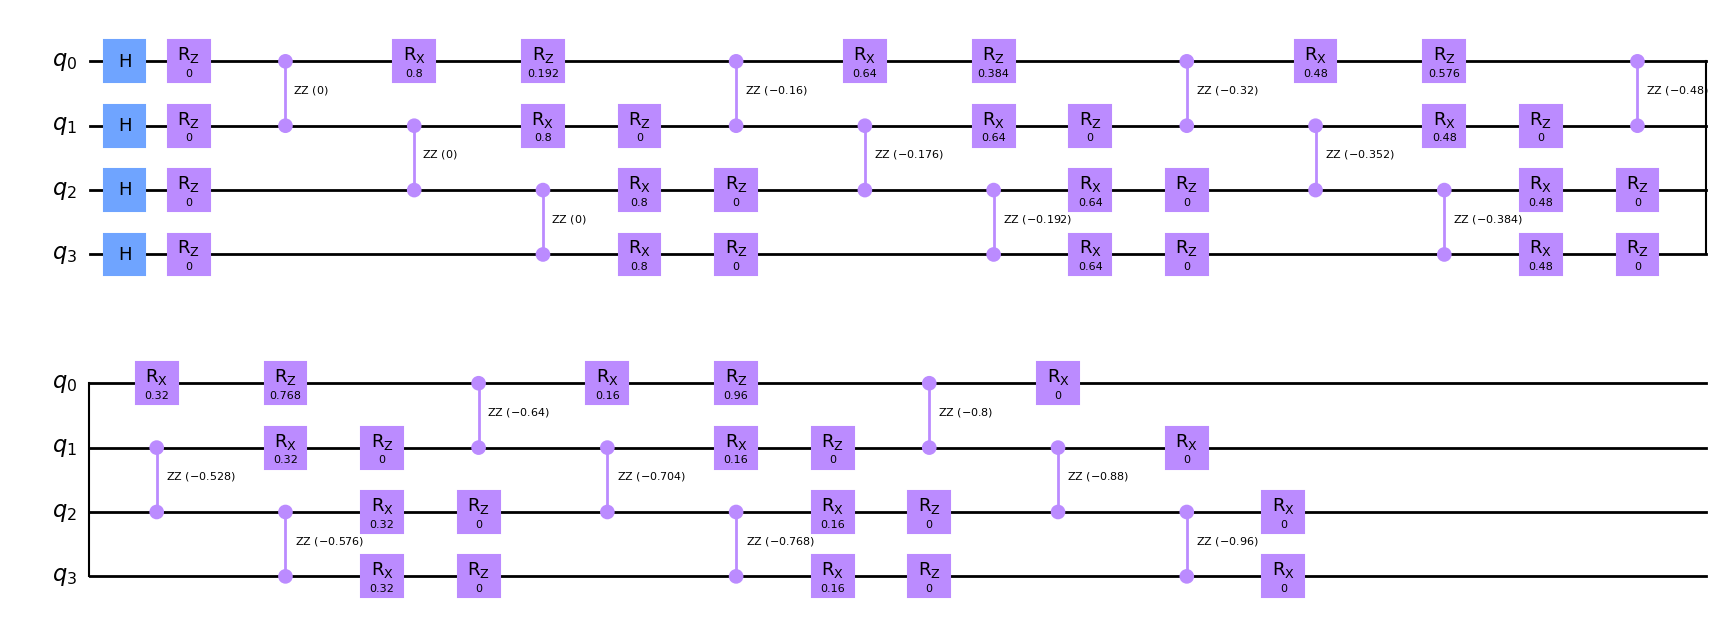

In [11]:
# Create the quantum circuit

circ = form_circuit(beta, ham)
circ.draw(output="mpl")

/tmp/ipykernel_520962/480607385.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result_sv = execute(circ, backend = sim).result()
/tmp/ipykernel_520962/480607385.py:4: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(result_sv.get_counts(circ))


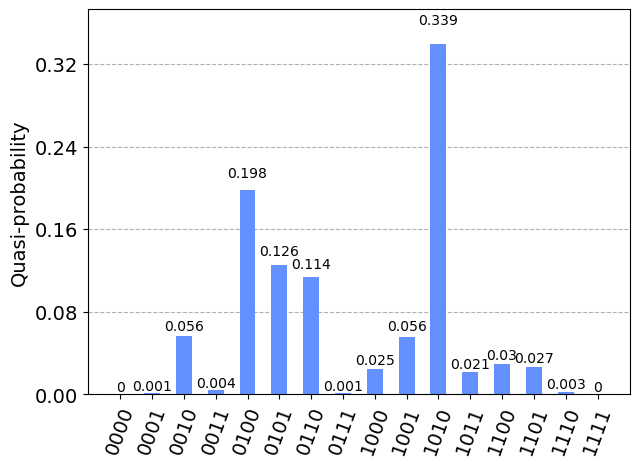

In [12]:
sim = Aer.get_backend('statevector_simulator')
result_sv = execute(circ, backend = sim).result()
state_vec = result_sv.get_statevector()
plot_histogram(result_sv.get_counts(circ))

In [13]:
samples = result_sv.get_counts(circ)
max(samples, key=samples.get)

'1010'

In [14]:
# Let's check to see that our answers are correct, by computing them directly (using adding the code you wrote in graph_energy.ipynb to your package)
emin, cmin = ham.get_lowest_energy_config(verbose=1)
print(" Energy minimum = %12.8f %s"%(emin, cmin))

AttributeError: 'IsingHamiltonian' object has no attribute 'get_lowest_energy_config'

**Note:** Since 0 and 1 have opposite meanings between the classical and quantum examples (0 was spin down classically, while $\ket{1}$ was the negative eigenvalue of $\hat{z}$), the bitstrings should be opposite one another. For example, the classical state `0101` corresponds to the `1010` state. However, Qiskit prints the bitstrings from right to left, whereas we print ours from left to write, so that means `1010` corresponds to `1010`, and `101` corresponds to `010`. 

# **Question**: 
What are the probabilities for measuring the correct bitstring using the following number of time steps (i.e., values of `n_steps`):
1.  `n_steps` = 3
1.  `n_steps` = 4
1.  `n_steps` = 8
1.  `n_steps` = 10 